# Optimization Algorithms

In the previous experiment, we have explored some variations of Gradient Descent, particularly, __mini-Batch Gradient Descent (mBGD)__, and __Stochastic Gradient Descent (SGD)__. Mini-batch Gradient Descent presents as a good alternative for Batch Gradient Descent, mainly because of its computation efficiency. In the future experiments, we will refer to the family of _vanilla_ Gradient Descent algorithms as SGD with variable batch size.

While SGD is effective in finding good sets of weights that minimize error, it turns out that Gradient Descent can further be improved by introducing more dynamic mechanism in adjusting of the model's weights. Think of SGD as _velocity_ in a world governed by classical Physics. If there's _velocity_, then there should also be _acceleration_, _momentum_, and such!

In this notebook, we'll implement __1st Moment__, __RMSprop__ and __Adam__ optimization algorithms. These algorithms describe _dynamic_ variations of SGD, and are considered to be improvement of the _dry_ SGD. In particular __RMSProp and Adam__ have been shown to work well across a wide range of deep learning architectures. 

* Adam: https://arxiv.org/abs/1412.6980
* RMSProp: https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mnist
from activation import relu, sigmoid, sigmoid_prime, softmax
from helper import one_hot_encoder
from initializer import initialize_weight
%matplotlib inline

from utils import dataloader
from losses import cross_entropy_loss

# Load Dataset
train_x, train_y = mnist.load_dataset(download=True, train=True)
test_x, test_y = mnist.load_dataset(download=True, train=False)

Found and verified data/t10k-images-idx3-ubyte.gz
Found and verified data/t10k-labels-idx1-ubyte.gz
Found and verified data/train-images-idx3-ubyte.gz
Found and verified data/train-labels-idx1-ubyte.gz
Found and verified data/t10k-images-idx3-ubyte.gz
Found and verified data/t10k-labels-idx1-ubyte.gz
Found and verified data/train-images-idx3-ubyte.gz
Found and verified data/train-labels-idx1-ubyte.gz


## 1st Moment

Here are the equations of weight updates using moment:

Keypoints of optimization using moments:

1. Moment takes into account the __history of gradient values__. This helps the algorithm in choosing whether to speed up or slow down the gradient descent, and therefore, smoothing the optimization.
2. Usual values of beta ranges from __0.8 to 0.999__. The most common value of beta is __0.9__.
3. One way of checking if your implementation of moment is correct is by setting the beta value to 0. Setting the beta value to 0 is the same as performing normal gradient descent.
4. __Larger to normal values of learning rate should be used__ when using 1st Moment optimization.

#### Tunable Hyperparameters:
* beta_1
* learning_rate

In [26]:
def train_moment(train_x, train_y, learning_rate=0.01, num_epochs=50, batch_size=None):
    # Flatten input (num_samples, 28, 28) -> (num_samples, 784) 
    x = train_x.reshape(train_x.shape[0], -1)
    num_samples = x.shape[0]
    
    # Turn labels into their one-hot representations
    y = one_hot_encoder(train_y)

    # Make a data loader
    trainloader = dataloader(x, y, batch_size=batch_size, shuffle=True)
    
    # Initialize weights
    w1, b1 = initialize_weight((784, 256), bias=True)
    w2, b2 = initialize_weight((256, 10), bias=True)

    # Initialize Moments
    v_w1, v_b1 = np.zeros(w1.shape), np.zeros(b1.shape)
    v_w2, v_b2 = np.zeros(w2.shape), np.zeros(b2.shape)
    
    # Optimizer Hyperparameters
    beta_1 = 0.9
    
    loss_history = []
    for epoch in range(1, num_epochs+1):
        print("Epoch {}/{}\n===============".format(epoch, num_epochs))

        batch_loss = 0
        acc = 0
        for inputs, labels in trainloader:
            # Number of samples per batch
            m = inputs.shape[0]
            
            # Forward Prop
            h1 = np.dot(inputs, w1) + b1
            a1 = sigmoid(h1)
            h2 = np.dot(a1, w2) + b2
            a2 = softmax(h2)
            out = a2

            # Cross Entropy Loss
            batch_loss += cross_entropy_loss(out, labels.argmax(axis=1).reshape(m,1))

            # Compute Accuracy
            pred = np.argmax(out, axis=1)
            pred = pred.reshape(pred.shape[0], 1)
            acc += np.sum(pred == labels.argmax(axis=1).reshape(m,1))

            # Backward Prop
            dh2 = a2 - labels 
            dw2 = (1/m) * np.dot(a1.T, dh2)
            db2 = (1/m) * np.sum(dh2, axis=0, keepdims=True)

            dh1 = np.dot(dh2, w2.T) * sigmoid_prime(a1)
            dw1 = (1/m) * np.dot(inputs.T, dh1)
            db1 = (1/m) * np.sum(dh1, axis=0, keepdims=True)

            # 1st Moment
            v_w2 = beta_1 * v_w2 + (1-beta_1) * dw2
            v_b2 = beta_1 * v_b2 + (1-beta_1) * db2
            v_w1 = beta_1 * v_w1 + (1-beta_1) * dw1
            v_b1 = beta_1 * v_b1 + (1-beta_1) * db1
            
            # Weight (and bias) update
            w1 -= learning_rate * v_w1
            b1 -= learning_rate * v_b1
            w2 -= learning_rate * v_w2
            b2 -= learning_rate * v_b2
            
        loss_history.append(batch_loss/num_samples)
        print("Loss: {:.6f}".format(batch_loss/num_samples))
        print("Accuracy: {:.2f}%\n".format(acc/num_samples*100))

    return w1, b1, w2, b2, loss_history

In [28]:
w1_m, b1_m, w2_m, b2_m, loss_history_m = train_moment(train_x, train_y, learning_rate=0.01, num_epochs=20, batch_size=64)

Epoch 1/20
Loss: 0.679610
Accuracy: 83.38%

Epoch 2/20
Loss: 0.342920
Accuracy: 90.96%

Epoch 3/20
Loss: 0.281672
Accuracy: 92.36%

Epoch 4/20
Loss: 0.247413
Accuracy: 93.29%

Epoch 5/20
Loss: 0.223667
Accuracy: 93.92%

Epoch 6/20
Loss: 0.204176
Accuracy: 94.44%

Epoch 7/20
Loss: 0.191056
Accuracy: 94.80%

Epoch 8/20
Loss: 0.176864
Accuracy: 95.11%

Epoch 9/20
Loss: 0.168828
Accuracy: 95.35%

Epoch 10/20
Loss: 0.160342
Accuracy: 95.62%

Epoch 11/20
Loss: 0.151357
Accuracy: 95.83%

Epoch 12/20
Loss: 0.144298
Accuracy: 96.04%

Epoch 13/20
Loss: 0.137218
Accuracy: 96.19%

Epoch 14/20
Loss: 0.131595
Accuracy: 96.45%

Epoch 15/20
Loss: 0.127305
Accuracy: 96.53%

Epoch 16/20
Loss: 0.122842
Accuracy: 96.73%

Epoch 17/20
Loss: 0.119617
Accuracy: 96.76%

Epoch 18/20
Loss: 0.115598
Accuracy: 96.86%

Epoch 19/20
Loss: 0.108998
Accuracy: 97.06%

Epoch 20/20
Loss: 0.106863
Accuracy: 97.11%



# RMSProp: 2nd Moment

Here are the equations of RMSProp:

Keypoints:

1. Usual values of __2nd moment beta is 0.999__.
2. A small number (epsilon) is added to the denominator to avoid division by zero. Typically, the value of epsilon is 1e-8, and this does not need any tuning.
3. __Smaller values of learning rate should be used__ when using RMSProp optimization.

#### Tunable Hyperparameters:
* beta_2
* learning_rate

In [4]:
def train_rmsprop(train_x, train_y, learning_rate=0.0001, num_epochs=50, batch_size=None):
    # Flatten input (num_samples, 28, 28) -> (num_samples, 784) 
    x = train_x.reshape(train_x.shape[0], -1)
    num_samples = x.shape[0]
    
    # Turn labels into their one-hot representations
    y = one_hot_encoder(train_y)

    # Make a data loader
    trainloader = dataloader(x, y, batch_size=batch_size, shuffle=True)
    
    # Initialize weights
    w1, b1 = initialize_weight((784, 256), bias=True)
    w2, b2 = initialize_weight((256, 10), bias=True)

    # Initialize Moments
    s_w1, s_b1 = np.zeros(w1.shape), np.zeros(b1.shape)
    s_w2, s_b2 = np.zeros(w2.shape), np.zeros(b2.shape)
    
    # Optimizer Hyperparameters
    beta_2 = 0.999
    epsilon = 1e-8
    
    loss_history = []
    for epoch in range(1, num_epochs+1):
        print("Epoch {}/{}\n===============".format(epoch, num_epochs))

        batch_loss = 0
        acc = 0
        for inputs, labels in trainloader:
            # Number of samples per batch
            m = inputs.shape[0]
            
            # Forward Prop
            h1 = np.dot(inputs, w1) + b1
            a1 = sigmoid(h1)
            h2 = np.dot(a1, w2) + b2
            a2 = softmax(h2)
            out = a2

            # Cross Entropy Loss
            batch_loss += cross_entropy_loss(out, labels.argmax(axis=1).reshape(m,1))

            # Compute Accuracy
            pred = np.argmax(out, axis=1)
            pred = pred.reshape(pred.shape[0], 1)
            acc += np.sum(pred == labels.argmax(axis=1).reshape(m,1))

            # Backward Prop
            dh2 = a2 - labels 
            dw2 = (1/m) * np.dot(a1.T, dh2)
            db2 = (1/m) * np.sum(dh2, axis=0, keepdims=True)

            dh1 = np.dot(dh2, w2.T) * sigmoid_prime(a1)
            dw1 = (1/m) * np.dot(inputs.T, dh1)
            db1 = (1/m) * np.sum(dh1, axis=0, keepdims=True)
            
            # 2nd Moment
            s_w2 = beta_2 * s_w2 + (1-beta_2) * dw2 * dw2
            s_b2 = beta_2 * s_b2 + (1-beta_2) * db2 * db2
            s_w1 = beta_2 * s_w1 + (1-beta_2) * dw1 * dw1
            s_b1 = beta_2 * s_b1 + (1-beta_2) * db1 * db1
            
            # Weight (and bias) update
            w1 -= learning_rate * dw1 / (np.sqrt(s_w1) + epsilon)
            b1 -= learning_rate * db1 / (np.sqrt(s_b1) + epsilon)
            w2 -= learning_rate * dw2 / (np.sqrt(s_w2) + epsilon)
            b2 -= learning_rate * db2 / (np.sqrt(s_b2) + epsilon)
            
        loss_history.append(batch_loss/num_samples)
        print("Loss: {:.6f}".format(batch_loss/num_samples))
        print("Accuracy: {:.2f}%\n".format(acc/num_samples*100))

    return w1, b1, w2, b2, loss_history

In [25]:
w1_r, b1_r, w2_r, b2_r, loss_history_r = train_rmsprop(train_x, train_y, learning_rate=0.0001, num_epochs=20, batch_size=64)

Epoch 1/20
Loss: 0.503672
Accuracy: 87.60%

Epoch 2/20
Loss: 0.296200
Accuracy: 92.02%

Epoch 3/20
Loss: 0.246794
Accuracy: 93.23%

Epoch 4/20
Loss: 0.219212
Accuracy: 93.90%

Epoch 5/20
Loss: 0.198185
Accuracy: 94.44%

Epoch 6/20
Loss: 0.181241
Accuracy: 94.89%

Epoch 7/20
Loss: 0.168127
Accuracy: 95.27%

Epoch 8/20
Loss: 0.157311
Accuracy: 95.53%

Epoch 9/20
Loss: 0.147967
Accuracy: 95.84%

Epoch 10/20
Loss: 0.138592
Accuracy: 96.12%

Epoch 11/20
Loss: 0.130903
Accuracy: 96.34%

Epoch 12/20
Loss: 0.124156
Accuracy: 96.51%

Epoch 13/20
Loss: 0.116830
Accuracy: 96.68%

Epoch 14/20
Loss: 0.111475
Accuracy: 96.88%

Epoch 15/20
Loss: 0.107178
Accuracy: 97.04%

Epoch 16/20
Loss: 0.100845
Accuracy: 97.19%

Epoch 17/20
Loss: 0.096173
Accuracy: 97.34%

Epoch 18/20
Loss: 0.092696
Accuracy: 97.41%

Epoch 19/20
Loss: 0.088006
Accuracy: 97.61%

Epoch 20/20
Loss: 0.085557
Accuracy: 97.63%



# Adam: Moment + RMSProp

Here are the equation for Adam algorithm:

Keypoints:

1. Usual values of 1st moment beta ranges from __0.8 to 0.999__. The most common value of beta is __0.9__.
2. Usual value of 2nd moment beta is __0.999__. 
3. Similar to RMSProp, a small number (epsilon) with a value of 1e-8 is added to the denominator to avoid math errors. 
4. Use normal values of learning_rate, in between 1st Moment's and RMSProp's. Whatever learning rate works for SGD, should also work for Adam.

#### Tunable Hyperparameters
* beta_1
* beta_2
* learning_rate

In [36]:
def train_adam(train_x, train_y, learning_rate=0.001, num_epochs=50, batch_size=None):
    # Flatten input (num_samples, 28, 28) -> (num_samples, 784) 
    x = train_x.reshape(train_x.shape[0], -1)
    num_samples = x.shape[0]
    
    # Turn labels into their one-hot representations
    y = one_hot_encoder(train_y)

    # Make a data loader
    trainloader = dataloader(x, y, batch_size=batch_size, shuffle=True)
    
    # Initialize weights
    w1, b1 = initialize_weight((784, 256), bias=True)
    w2, b2 = initialize_weight((256, 10), bias=True)

    # Initialize Moments
    s_w1, s_b1 = np.zeros(w1.shape), np.zeros(b1.shape)
    s_w2, s_b2 = np.zeros(w2.shape), np.zeros(b2.shape)
    v_w1, v_b1 = np.zeros(w1.shape), np.zeros(b1.shape)
    v_w2, v_b2 = np.zeros(w2.shape), np.zeros(b2.shape)
    
    # Optimizer Hyperparameters
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8
    
    loss_history = []
    for epoch in range(1, num_epochs+1):
        print("Epoch {}/{}\n===============".format(epoch, num_epochs))

        batch_loss = 0
        acc = 0
        for inputs, labels in trainloader:
            # Number of samples per batch
            m = inputs.shape[0]
            
            # Forward Prop
            h1 = np.dot(inputs, w1) + b1
            a1 = sigmoid(h1)
            h2 = np.dot(a1, w2) + b2
            a2 = softmax(h2)
            out = a2

            # Cross Entropy Loss
            batch_loss += cross_entropy_loss(out, labels.argmax(axis=1).reshape(m,1))

            # Compute Accuracy
            pred = np.argmax(out, axis=1)
            pred = pred.reshape(pred.shape[0], 1)
            acc += np.sum(pred == labels.argmax(axis=1).reshape(m,1))

            # Backward Prop
            dh2 = a2 - labels 
            dw2 = (1/m) * np.dot(a1.T, dh2)
            db2 = (1/m) * np.sum(dh2, axis=0, keepdims=True)

            dh1 = np.dot(dh2, w2.T) * sigmoid_prime(a1)
            dw1 = (1/m) * np.dot(inputs.T, dh1)
            db1 = (1/m) * np.sum(dh1, axis=0, keepdims=True)

            # 1st Moment
            v_w2 = beta_1 * v_w2 + (1-beta_1) * dw2
            v_b2 = beta_1 * v_b2 + (1-beta_1) * db2
            v_w1 = beta_1 * v_w1 + (1-beta_1) * dw1
            v_b1 = beta_1 * v_b1 + (1-beta_1) * db1
            
            # 2nd Moment
            s_w2 = beta_2 * s_w2 + (1-beta_2) * dw2 * dw2
            s_b2 = beta_2 * s_b2 + (1-beta_2) * db2 * db2
            s_w1 = beta_2 * s_w1 + (1-beta_2) * dw1 * dw1
            s_b1 = beta_2 * s_b1 + (1-beta_2) * db1 * db1
            
            # Weight (and bias) update
            w1 -= learning_rate * v_w1 / (np.sqrt(s_w1) + epsilon)
            b1 -= learning_rate * v_b1 / (np.sqrt(s_b1) + epsilon)
            w2 -= learning_rate * v_w2 / (np.sqrt(s_w2) + epsilon)
            b2 -= learning_rate * v_b2 / (np.sqrt(s_b2) + epsilon)
            
        loss_history.append(batch_loss/num_samples)
        print("Loss: {:.6f}".format(batch_loss/num_samples))
        print("Accuracy: {:.2f}%\n".format(acc/num_samples*100))

    return w1, b1, w2, b2, loss_history

In [37]:
w1_a, b1_a, w2_a, b2_a, loss_history_a = train_adam(train_x, train_y, learning_rate=0.0002, num_epochs=20, batch_size=64)

Epoch 1/20
Loss: 0.450903
Accuracy: 88.27%

Epoch 2/20
Loss: 0.258609
Accuracy: 92.80%

Epoch 3/20
Loss: 0.220338
Accuracy: 93.78%

Epoch 4/20
Loss: 0.189961
Accuracy: 94.55%

Epoch 5/20
Loss: 0.175986
Accuracy: 94.99%

Epoch 6/20
Loss: 0.160359
Accuracy: 95.43%

Epoch 7/20
Loss: 0.148074
Accuracy: 95.74%

Epoch 8/20
Loss: 0.137862
Accuracy: 95.97%

Epoch 9/20
Loss: 0.131753
Accuracy: 96.22%

Epoch 10/20
Loss: 0.126759
Accuracy: 96.33%

Epoch 11/20
Loss: 0.119713
Accuracy: 96.51%

Epoch 12/20
Loss: 0.113012
Accuracy: 96.70%

Epoch 13/20
Loss: 0.107655
Accuracy: 96.89%

Epoch 14/20
Loss: 0.105729
Accuracy: 96.87%

Epoch 15/20
Loss: 0.099434
Accuracy: 97.11%

Epoch 16/20
Loss: 0.098018
Accuracy: 97.12%

Epoch 17/20
Loss: 0.095806
Accuracy: 97.21%

Epoch 18/20
Loss: 0.092298
Accuracy: 97.30%

Epoch 19/20
Loss: 0.086160
Accuracy: 97.51%

Epoch 20/20
Loss: 0.085433
Accuracy: 97.56%



# Vanilla Gradient Descent

In [16]:
def train(train_x, train_y, learning_rate=0.1, num_epochs=50, batch_size=1):
    # Flatten input (num_samples, 28, 28) -> (num_samples, 784) 
    x = train_x.reshape(train_x.shape[0], -1)
    num_samples = x.shape[0]
    
    # Turn labels into their one-hot representations
    y = one_hot_encoder(train_y)

    # Make a data loader
    trainloader = dataloader(x, y, batch_size=batch_size, shuffle=True)
    
    # Initialize weights
    w1, b1 = initialize_weight((784, 256), bias=True)
    w2, b2 = initialize_weight((256, 10), bias=True)

    loss_history = []
    for epoch in range(1, num_epochs+1):
        print("Epoch {}/{}\n===============".format(epoch, num_epochs))

        batch_loss = 0
        acc = 0
        for inputs, labels in trainloader:
            # Number of samples per batch
            m = inputs.shape[0]
            
            # Forward Prop
            h1 = np.dot(inputs, w1) + b1
            a1 = sigmoid(h1)
            h2 = np.dot(a1, w2) + b2
            a2 = softmax(h2)
            out = a2

            # Cross Entropy Loss
            batch_loss += cross_entropy_loss(out, labels.argmax(axis=1).reshape(m,1))

            # Compute Accuracy
            pred = np.argmax(out, axis=1)
            pred = pred.reshape(pred.shape[0], 1)
            acc += np.sum(pred == labels.argmax(axis=1).reshape(m,1))

            # Backward Prop
            dh2 = a2 - labels 
            dw2 = (1/m) * np.dot(a1.T, dh2)
            db2 = (1/m) * np.sum(dh2, axis=0, keepdims=True)

            dh1 = np.dot(dh2, w2.T) * sigmoid_prime(a1)
            dw1 = (1/m) * np.dot(inputs.T, dh1)
            db1 = (1/m) * np.sum(dh1, axis=0, keepdims=True)

            # Weight (and bias) update
            w1 -= learning_rate * dw1
            b1 -= learning_rate * db1
            w2 -= learning_rate * dw2
            b2 -= learning_rate * db2
            
        loss_history.append(batch_loss/num_samples)
        print("Loss: {:.6f}".format(batch_loss/num_samples))
        print("Accuracy: {:.2f}%\n".format(acc/num_samples*100))

    return w1, b1, w2, b2, loss_history

In [29]:
w1_mbgd, b1_mbgd, w2_mbgd, b2_mbgd, loss_history_mbgd = train(train_x, train_y, learning_rate=0.005, num_epochs=20, batch_size=64)

Epoch 1/20
Loss: 0.862686
Accuracy: 79.84%

Epoch 2/20
Loss: 0.425613
Accuracy: 89.46%

Epoch 3/20
Loss: 0.339804
Accuracy: 91.18%

Epoch 4/20
Loss: 0.295572
Accuracy: 92.16%

Epoch 5/20
Loss: 0.265906
Accuracy: 92.87%

Epoch 6/20
Loss: 0.244839
Accuracy: 93.41%

Epoch 7/20
Loss: 0.225978
Accuracy: 93.92%

Epoch 8/20
Loss: 0.212800
Accuracy: 94.23%

Epoch 9/20
Loss: 0.201151
Accuracy: 94.55%

Epoch 10/20
Loss: 0.189974
Accuracy: 94.86%

Epoch 11/20
Loss: 0.180166
Accuracy: 95.04%

Epoch 12/20
Loss: 0.172098
Accuracy: 95.37%

Epoch 13/20
Loss: 0.164900
Accuracy: 95.58%

Epoch 14/20
Loss: 0.157727
Accuracy: 95.85%

Epoch 15/20
Loss: 0.151278
Accuracy: 95.95%

Epoch 16/20
Loss: 0.146804
Accuracy: 96.14%

Epoch 17/20
Loss: 0.141740
Accuracy: 96.26%

Epoch 18/20
Loss: 0.135459
Accuracy: 96.48%

Epoch 19/20
Loss: 0.130371
Accuracy: 96.62%

Epoch 20/20
Loss: 0.126228
Accuracy: 96.76%



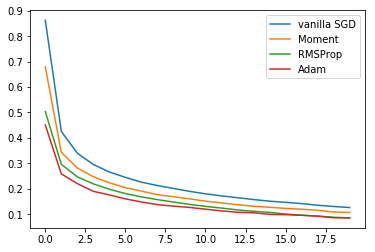

In [39]:
# Plot and Compare Losses
plt.plot(loss_history_mbgd, label="vanilla SGD")
plt.plot(loss_history_m, label="Moment")
plt.plot(loss_history_r, label="RMSProp")
plt.plot(loss_history_a, label="Adam")
plt.legend()

## Conclusion

So let's analyze the graph above. As expected based on the discussions above, the 3 new optimization algorithms outperform SGD. Adam performed slightly better than RMSProp. Notice that these optimizers are highly affected by the choice of learning rate. 

### Learning Rate Choice
Listed below is the trend of the values of effective learning rates, with the top requiring the largest largest value:
1. Moment
2. Vanilla SGD
3. Adam
4. RMSProp


### Power-Performance Trade-off 
Also, take note that vanilla SGD requires the least computational power, but it performs the worst in terms of loss and accuracy. We are therefore presented with _computation power vs performance trade off_. With increasing performance potential, more computation power is needed.

Trend of decreasing performance:
1. Adam
2. RMSProp
3. Moment
4. vanilla SGD

Trend of decreasing computation power needed: 
1. vanilla SGD,
2. Moment
3. RMSProp
4. Adam